<a href="https://www.kaggle.com/code/vtrackstar/2024-wnba-bigs-linear-regression-and-kmeans?scriptVersionId=210006722" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Prepare

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
pd.set_option('display.max_columns', None)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wnba2024stats/2024 WNBA Player Stats - Shooting.csv
/kaggle/input/wnba2024stats/2024 WNBA Player Stats - Advanced.csv
/kaggle/input/wnba2024stats/2024 WNBA Player Stats - PerGame.csv
/kaggle/input/wnba2024stats/2024 WNBA Player Stats - PlaybyPlay.csv


In [2]:
pergame = pd.read_csv('/kaggle/input/wnba2024stats/2024 WNBA Player Stats - PerGame.csv')
advanced = pd.read_csv('/kaggle/input/wnba2024stats/2024 WNBA Player Stats - Advanced.csv')
playbyplay = pd.read_csv('/kaggle/input/wnba2024stats/2024 WNBA Player Stats - PlaybyPlay.csv')
shooting = pd.read_csv('/kaggle/input/wnba2024stats/2024 WNBA Player Stats - Shooting.csv')

In [3]:
advanced1 = advanced[['Player', 'PER', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'OWS', 'DWS', 'WS', 'WS/40']]
pbp = playbyplay[['Player', 'OnCourt', 'On-Off', 'BadPassTO', 'LostBallTO', 'ShootFoulCmtd', 'OffFoulCmtd', 'ShootFoulDrawn', 'OffFoulCmtd.1', 'PtsGenbyAsts', 'And1s', 'FGA_Blkd']]
shot = shooting[['Player', 'AvgFGDist', '%FGA_2P', '%FGA_0-3', '%FGA_3-10', '%FGA_10-16', '%FGA_16-3P', '%FGA_3P', 'FG%_2P', 'FG%_0-3', 'FG%_3-10', 'FG%_10-16', 'FG%_16-3P', 'FG%_3P', '%FGA_Astd_2P', '%FGA_Astd_3P', '%3PA_Corner', '3P%_Corner']]
merged1 = pd.merge(pergame, advanced1, on='Player', how='left').merge(pbp, on='Player', how='left').merge(shot, on='Player', how='left')
merged = merged1.drop(['G.1', 'MP.1'], axis=1)
merged.head()

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,eFG%,3PAr,FTr,ORB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/40,OnCourt,On-Off,BadPassTO,LostBallTO,ShootFoulCmtd,OffFoulCmtd,ShootFoulDrawn,OffFoulCmtd.1,PtsGenbyAsts,And1s,FGA_Blkd,AvgFGDist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,FG%_2P,FG%_0-3,FG%_3-10,FG%_10-16,FG%_16-3P,FG%_3P,%FGA_Astd_2P,%FGA_Astd_3P,%3PA_Corner,3P%_Corner
0,A'ja Wilson,LVA,C,38,1308,38,10.1,19.6,0.518,0.5,1.6,0.317,9.6,18.0,0.536,6.1,7.2,0.844,2.1,11.9,2.3,1.8,2.6,1.3,1.8,26.9,34.9,0.591,0.531,0.081,0.370,7.2,19.9,14.1,2.6,6.3,5.3,32.2,119,92,7.0,3.8,10.9,0.332,6.5,-2.7,20,17,42,9,131,2,223,30,48,10.4,0.919,0.162,0.350,0.246,0.162,0.081,0.536,0.692,0.554,0.421,0.517,0.317,0.699,1.000,0.117,0.286
1,Arike Ogunbowale,DAL,G,38,1465,38,7.3,19.2,0.383,2.9,8.5,0.346,4.4,10.7,0.412,4.6,5.0,0.921,0.8,4.6,5.1,2.1,0.3,2.7,2.8,22.2,18.6,0.520,0.460,0.444,0.261,2.3,7.0,22.4,2.8,0.6,11.2,26.8,108,114,3.7,-0.4,3.3,0.089,-8.3,13.8,68,12,26,19,73,11,430,13,21,17.5,0.556,0.093,0.118,0.181,0.163,0.444,0.412,0.559,0.337,0.364,0.437,0.346,0.359,0.643,0.071,0.348
2,Kahleah Copper,PHO,G-F,37,1197,37,7.4,17.0,0.435,1.9,5.9,0.314,5.5,11.0,0.500,4.5,5.6,0.807,0.6,4.5,2.3,0.8,0.1,3.0,3.3,21.1,16.4,0.544,0.490,0.350,0.330,2.4,8.2,14.2,1.2,0.2,13.3,31.8,99,111,0.9,0.2,1.1,0.037,-5.4,-3.4,45,45,38,12,98,7,205,17,46,13.6,0.650,0.205,0.223,0.108,0.113,0.350,0.500,0.729,0.386,0.471,0.338,0.314,0.446,0.942,0.218,0.292
3,Napheesa Collier,MIN,F,34,1181,34,7.9,16.0,0.492,0.9,2.9,0.310,7.0,13.1,0.533,3.7,4.6,0.804,2.2,9.7,3.4,1.9,1.4,2.1,2.6,20.4,25.1,0.565,0.520,0.183,0.290,7.8,16.2,18.8,2.8,3.6,10.2,26.7,112,91,3.7,3.7,7.4,0.250,13.9,20.2,21,27,37,14,72,5,292,19,37,10.8,0.817,0.215,0.336,0.160,0.106,0.183,0.533,0.701,0.443,0.483,0.552,0.310,0.734,0.968,0.110,0.545
4,Breanna Stewart,NYL,F,38,1243,38,7.0,15.2,0.458,1.2,4.1,0.295,5.8,11.1,0.519,5.3,6.3,0.845,1.6,8.5,3.5,1.7,1.3,1.7,2.1,20.4,26.4,0.569,0.498,0.270,0.412,5.8,15.0,19.4,2.6,3.3,8.7,27.1,117,94,5.4,3.4,8.7,0.281,11.4,0.4,28,12,31,17,111,3,347,19,21,12.2,0.730,0.161,0.332,0.189,0.048,0.270,0.519,0.753,0.505,0.404,0.286,0.295,0.749,0.870,0.167,0.346


In [4]:
big = merged[(merged['Pos'] == 'C') | (merged['Pos'] == 'F-C') | ((merged['Pos'] == 'F') & ((merged['%FGA_0-3'] + merged['%FGA_3-10']) >= 0.60))]
big

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,eFG%,3PAr,FTr,ORB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/40,OnCourt,On-Off,BadPassTO,LostBallTO,ShootFoulCmtd,OffFoulCmtd,ShootFoulDrawn,OffFoulCmtd.1,PtsGenbyAsts,And1s,FGA_Blkd,AvgFGDist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,FG%_2P,FG%_0-3,FG%_3-10,FG%_10-16,FG%_16-3P,FG%_3P,%FGA_Astd_2P,%FGA_Astd_3P,%3PA_Corner,3P%_Corner
0,A'ja Wilson,LVA,C,38,1308,38,10.1,19.6,0.518,0.5,1.6,0.317,9.6,18.0,0.536,6.1,7.2,0.844,2.1,11.9,2.3,1.8,2.6,1.3,1.8,26.9,34.9,0.591,0.531,0.081,0.370,7.2,19.9,14.1,2.6,6.3,5.3,32.2,119,92,7.0,3.8,10.9,0.332,6.5,-2.7,20,17,42,9,131,2,223,30,48,10.4,0.919,0.162,0.350,0.246,0.162,0.081,0.536,0.692,0.554,0.421,0.517,0.317,0.699,1.000,0.117,0.286
10,Brittney Griner,PHO,C,30,861,30,7.3,12.6,0.579,0.3,0.6,0.500,7.0,12.0,0.583,2.9,3.7,0.777,1.8,6.6,2.3,0.5,1.5,1.8,1.9,17.8,26.0,0.625,0.591,0.048,0.296,7.5,13.3,17.1,1.0,4.8,11.0,25.6,117,107,3.4,0.6,4.0,0.187,-0.2,9.2,18,11,18,20,63,2,173,22,9,8.0,0.952,0.238,0.481,0.156,0.077,0.048,0.583,0.856,0.560,0.356,0.345,0.500,0.790,0.889,0.111,0.500
12,Natasha Howard,DAL,F,27,825,26,6.9,15.2,0.456,0.4,2.0,0.200,6.5,13.1,0.496,3.3,4.6,0.718,2.0,6.7,2.9,1.3,0.8,2.8,3.1,17.6,18.1,0.510,0.470,0.134,0.302,7.5,13.1,17.0,2.1,2.2,14.1,28.1,100,112,0.9,-0.1,0.8,0.039,-8.1,3.1,35,12,45,11,53,6,178,7,15,9.7,0.866,0.234,0.368,0.180,0.083,0.134,0.496,0.708,0.497,0.297,0.324,0.200,0.716,1.000,0.145,0.250
14,Dearica Hamby,LAS,F,40,1346,40,6.7,13.1,0.512,0.8,2.2,0.341,6.0,10.9,0.547,3.1,5.0,0.631,1.5,9.2,3.5,1.7,0.2,3.0,2.8,17.3,19.2,0.566,0.541,0.168,0.379,5.4,16.5,20.6,2.5,0.5,16.2,24.1,103,104,1.9,1.5,3.4,0.101,-10.5,-5.1,36,43,44,22,99,3,328,25,75,7.6,0.832,0.411,0.369,0.033,0.019,0.168,0.547,0.647,0.477,0.294,0.200,0.341,0.714,1.000,0.068,0.333
23,Tina Charles,ATL,C,39,1160,39,6.2,13.7,0.456,0.3,1.1,0.262,5.9,12.6,0.473,2.2,2.7,0.785,2.5,9.6,2.3,0.9,0.5,1.6,2.5,14.9,19.5,0.501,0.466,0.079,0.201,9.3,18.4,16.0,1.6,1.6,9.5,25.0,103,100,1.7,2.0,3.7,0.129,0.8,15.5,23,9,39,15,49,3,207,11,29,9.8,0.921,0.229,0.332,0.197,0.163,0.079,0.473,0.607,0.429,0.410,0.448,0.262,0.711,1.000,0.143,0.000
26,Jonquel Jones,NYL,C,39,1164,39,5.3,9.8,0.538,1.5,3.9,0.388,3.8,5.9,0.636,2.1,2.7,0.788,1.7,9.0,3.2,0.8,1.3,2.4,2.9,14.2,21.4,0.645,0.615,0.397,0.272,6.8,17.4,18.3,1.3,3.7,17.7,20.1,116,95,3.6,2.9,6.5,0.223,13.1,6.1,36,20,41,29,48,3,309,14,18,13.0,0.605,0.259,0.241,0.055,0.050,0.395,0.636,0.768,0.609,0.429,0.316,0.391,0.782,0.966,0.119,0.611
27,Aliyah Boston,IND,F-C,40,1236,40,5.9,11.2,0.529,0.2,0.7,0.269,5.7,10.5,0.545,2.0,2.8,0.736,2.8,8.9,3.2,0.9,1.2,2.0,3.3,14.0,20.4,0.566,0.537,0.058,0.247,10.7,16.8,17.3,1.4,3.5,13.8,20.6,114,107,3.6,0.9,4.5,0.147,-1.9,7.0,27,12,59,20,52,3,313,10,40,6.3,0.942,0.484,0.287,0.101,0.070,0.058,0.545,0.644,0.469,0.467,0.290,0.269,0.638,0.857,0.231,0.167
28,Brionna Jones,CON,F,40,1087,40,5.5,10.2,0.538,0.1,0.4,0.143,5.5,9.9,0.552,2.7,3.6,0.738,2.2,5.5,1.5,1.2,0.6,1.3,2.7,13.7,21.2,0.581,0.540,0.034,0.355,9.6,12.6,10.5,2.2,2.0,9.7,22.3,115,96,3.5,2.5,6.0,0.222,13.1,12.8,18,17,48,8,74,8,139,15,31,6.2,0.966,0.409,0.387,0.091,0.078,0.034,0.553,0.653,0.481,0.514,0.438,0.143,0.748,1.000,0.000,NaN
29,Angel Reese,CHI,F,34,1104,34,4.8,12.3,0.391,0.1,0.5,0.188,4.7,11.9,0.400,3.9,5.2,0.736,5.1,13.1,1.9,1.3,0.5,2.2,3.5,13.6,17.6,0.464,0.395,0.038,0.425,16.9,23.0,9.6,2.0,1.3,13.1,22.7,101,102,1.1,1.6,2.7,0.098,0.0,20.5,23,18,42,17,84,1,141,19,76,5.2,0.962,0.556,0.296,0.024,0.086,0.038,0.400,0.498,0.250,0.400,0.278,0.188,0.627,0.667,0.125,0.500
36,Ezi Magbegor,SEA,F-C,37,1135,37,4.6,9.1,0.512,0.4,1.4,0.245,4.3,7.6,0.562,2.1,2.4,0.874,2.2,8.0,2.0,1.1,2.2,1.4,3.2,11.7,19.2,0.578,0.531,0.158,0.259,8.2,14.9,10.5,1.8,6.2,12.4,16.5,114,96,2.7,2.7,5.4,0.191,7.2,5.8,17,17,71,6,42,2,174,8,39,8.1,0.842,0.330,0.420,0.063,0.030,0.158,0.562,0.721,0.418,0.667,0.600,0.245,0.786,1.000,0.208,0.182


In [5]:
columns = ['%FGA_0-3', '%FGA_3-10', 'FGA', 'FG%_0-3', 'FG%_3-10']
big.loc[:, columns] = big.loc[:, columns].fillna(0)
print(big[columns].isnull().sum())

%FGA_0-3     0
%FGA_3-10    0
FGA          0
FG%_0-3      0
FG%_3-10     0
dtype: int64


In [6]:
bigs = big.copy()
bigs['%FGA_0-10'] = bigs['%FGA_0-3'] + bigs['%FGA_3-10']
bigs['FGA_0-10'] = bigs['%FGA_0-10'] * bigs['FGA']
bigs['FGM_0-10'] = (bigs['FG%_0-3'] * (bigs['%FGA_0-3'] * bigs['FGA'])) + (bigs['FG%_3-10'] * (bigs['%FGA_3-10'] * bigs['FGA']))
bigs['FG%_0-10'] = bigs['FGM_0-10'] / (bigs['%FGA_0-10'] * bigs['FGA'])
bigs['FGA_0-10Tot'] = bigs['FGA_0-10'] * bigs['G']
bigs.head()

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,eFG%,3PAr,FTr,ORB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/40,OnCourt,On-Off,BadPassTO,LostBallTO,ShootFoulCmtd,OffFoulCmtd,ShootFoulDrawn,OffFoulCmtd.1,PtsGenbyAsts,And1s,FGA_Blkd,AvgFGDist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,FG%_2P,FG%_0-3,FG%_3-10,FG%_10-16,FG%_16-3P,FG%_3P,%FGA_Astd_2P,%FGA_Astd_3P,%3PA_Corner,3P%_Corner,%FGA_0-10,FGA_0-10,FGM_0-10,FG%_0-10,FGA_0-10Tot
0,A'ja Wilson,LVA,C,38,1308,38,10.1,19.6,0.518,0.5,1.6,0.317,9.6,18.0,0.536,6.1,7.2,0.844,2.1,11.9,2.3,1.8,2.6,1.3,1.8,26.9,34.9,0.591,0.531,0.081,0.370,7.2,19.9,14.1,2.6,6.3,5.3,32.2,119,92,7.0,3.8,10.9,0.332,6.5,-2.7,20,17,42,9,131,2,223,30,48,10.4,0.919,0.162,0.350,0.246,0.162,0.081,0.536,0.692,0.554,0.421,0.517,0.317,0.699,1.000,0.117,0.286,0.512,10.0352,5.997678,0.597664,381.3376
10,Brittney Griner,PHO,C,30,861,30,7.3,12.6,0.579,0.3,0.6,0.500,7.0,12.0,0.583,2.9,3.7,0.777,1.8,6.6,2.3,0.5,1.5,1.8,1.9,17.8,26.0,0.625,0.591,0.048,0.296,7.5,13.3,17.1,1.0,4.8,11.0,25.6,117,107,3.4,0.6,4.0,0.187,-0.2,9.2,18,11,18,20,63,2,173,22,9,8.0,0.952,0.238,0.481,0.156,0.077,0.048,0.583,0.856,0.560,0.356,0.345,0.500,0.790,0.889,0.111,0.500,0.719,9.0594,5.960909,0.657981,271.7820
12,Natasha Howard,DAL,F,27,825,26,6.9,15.2,0.456,0.4,2.0,0.200,6.5,13.1,0.496,3.3,4.6,0.718,2.0,6.7,2.9,1.3,0.8,2.8,3.1,17.6,18.1,0.510,0.470,0.134,0.302,7.5,13.1,17.0,2.1,2.2,14.1,28.1,100,112,0.9,-0.1,0.8,0.039,-8.1,3.1,35,12,45,11,53,6,178,7,15,9.7,0.866,0.234,0.368,0.180,0.083,0.134,0.496,0.708,0.497,0.297,0.324,0.200,0.716,1.000,0.145,0.250,0.602,9.1504,5.298234,0.579017,247.0608
14,Dearica Hamby,LAS,F,40,1346,40,6.7,13.1,0.512,0.8,2.2,0.341,6.0,10.9,0.547,3.1,5.0,0.631,1.5,9.2,3.5,1.7,0.2,3.0,2.8,17.3,19.2,0.566,0.541,0.168,0.379,5.4,16.5,20.6,2.5,0.5,16.2,24.1,103,104,1.9,1.5,3.4,0.101,-10.5,-5.1,36,43,44,22,99,3,328,25,75,7.6,0.832,0.411,0.369,0.033,0.019,0.168,0.547,0.647,0.477,0.294,0.200,0.341,0.714,1.000,0.068,0.333,0.780,10.2180,5.789283,0.566577,408.7200
23,Tina Charles,ATL,C,39,1160,39,6.2,13.7,0.456,0.3,1.1,0.262,5.9,12.6,0.473,2.2,2.7,0.785,2.5,9.6,2.3,0.9,0.5,1.6,2.5,14.9,19.5,0.501,0.466,0.079,0.201,9.3,18.4,16.0,1.6,1.6,9.5,25.0,103,100,1.7,2.0,3.7,0.129,0.8,15.5,23,9,39,15,49,3,207,11,29,9.8,0.921,0.229,0.332,0.197,0.163,0.079,0.473,0.607,0.429,0.410,0.448,0.262,0.711,1.000,0.143,0.000,0.561,7.6857,3.855605,0.501660,299.7423


## Process

In [7]:
X = bigs[['FGA_0-10Tot']]
y = bigs['FG%_0-10']

X = X.fillna(0)
y = y.fillna(0)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
bigs['FG%_predicted'] = model.predict(X_scaled)
bigs['FG%_difference'] = bigs['FG%_0-10'] - bigs['FG%_predicted']
bigs.head()

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,eFG%,3PAr,FTr,ORB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/40,OnCourt,On-Off,BadPassTO,LostBallTO,ShootFoulCmtd,OffFoulCmtd,ShootFoulDrawn,OffFoulCmtd.1,PtsGenbyAsts,And1s,FGA_Blkd,AvgFGDist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,FG%_2P,FG%_0-3,FG%_3-10,FG%_10-16,FG%_16-3P,FG%_3P,%FGA_Astd_2P,%FGA_Astd_3P,%3PA_Corner,3P%_Corner,%FGA_0-10,FGA_0-10,FGM_0-10,FG%_0-10,FGA_0-10Tot,FG%_predicted,FG%_difference
0,A'ja Wilson,LVA,C,38,1308,38,10.1,19.6,0.518,0.5,1.6,0.317,9.6,18.0,0.536,6.1,7.2,0.844,2.1,11.9,2.3,1.8,2.6,1.3,1.8,26.9,34.9,0.591,0.531,0.081,0.370,7.2,19.9,14.1,2.6,6.3,5.3,32.2,119,92,7.0,3.8,10.9,0.332,6.5,-2.7,20,17,42,9,131,2,223,30,48,10.4,0.919,0.162,0.350,0.246,0.162,0.081,0.536,0.692,0.554,0.421,0.517,0.317,0.699,1.000,0.117,0.286,0.512,10.0352,5.997678,0.597664,381.3376,0.629087,-0.031423
10,Brittney Griner,PHO,C,30,861,30,7.3,12.6,0.579,0.3,0.6,0.500,7.0,12.0,0.583,2.9,3.7,0.777,1.8,6.6,2.3,0.5,1.5,1.8,1.9,17.8,26.0,0.625,0.591,0.048,0.296,7.5,13.3,17.1,1.0,4.8,11.0,25.6,117,107,3.4,0.6,4.0,0.187,-0.2,9.2,18,11,18,20,63,2,173,22,9,8.0,0.952,0.238,0.481,0.156,0.077,0.048,0.583,0.856,0.560,0.356,0.345,0.500,0.790,0.889,0.111,0.500,0.719,9.0594,5.960909,0.657981,271.7820,0.586617,0.071363
12,Natasha Howard,DAL,F,27,825,26,6.9,15.2,0.456,0.4,2.0,0.200,6.5,13.1,0.496,3.3,4.6,0.718,2.0,6.7,2.9,1.3,0.8,2.8,3.1,17.6,18.1,0.510,0.470,0.134,0.302,7.5,13.1,17.0,2.1,2.2,14.1,28.1,100,112,0.9,-0.1,0.8,0.039,-8.1,3.1,35,12,45,11,53,6,178,7,15,9.7,0.866,0.234,0.368,0.180,0.083,0.134,0.496,0.708,0.497,0.297,0.324,0.200,0.716,1.000,0.145,0.250,0.602,9.1504,5.298234,0.579017,247.0608,0.577034,0.001982
14,Dearica Hamby,LAS,F,40,1346,40,6.7,13.1,0.512,0.8,2.2,0.341,6.0,10.9,0.547,3.1,5.0,0.631,1.5,9.2,3.5,1.7,0.2,3.0,2.8,17.3,19.2,0.566,0.541,0.168,0.379,5.4,16.5,20.6,2.5,0.5,16.2,24.1,103,104,1.9,1.5,3.4,0.101,-10.5,-5.1,36,43,44,22,99,3,328,25,75,7.6,0.832,0.411,0.369,0.033,0.019,0.168,0.547,0.647,0.477,0.294,0.200,0.341,0.714,1.000,0.068,0.333,0.780,10.2180,5.789283,0.566577,408.7200,0.639702,-0.073125
23,Tina Charles,ATL,C,39,1160,39,6.2,13.7,0.456,0.3,1.1,0.262,5.9,12.6,0.473,2.2,2.7,0.785,2.5,9.6,2.3,0.9,0.5,1.6,2.5,14.9,19.5,0.501,0.466,0.079,0.201,9.3,18.4,16.0,1.6,1.6,9.5,25.0,103,100,1.7,2.0,3.7,0.129,0.8,15.5,23,9,39,15,49,3,207,11,29,9.8,0.921,0.229,0.332,0.197,0.163,0.079,0.473,0.607,0.429,0.410,0.448,0.262,0.711,1.000,0.143,0.000,0.561,7.6857,3.855605,0.501660,299.7423,0.597456,-0.095797


In [10]:
## K Means Feature Engineering
bigs_features = bigs[['%FGA_0-10', '%FGA_3P', 'AvgFGDist']]
bigs_scaled = pd.DataFrame(scaler.fit_transform(bigs_features), columns=bigs_features.columns)
kmeans_bigs = KMeans(n_clusters=3, random_state=42, n_init=15)
bigs['Cluster'] = kmeans_bigs.fit_predict(bigs_scaled)

In [11]:
bigs

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,eFG%,3PAr,FTr,ORB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/40,OnCourt,On-Off,BadPassTO,LostBallTO,ShootFoulCmtd,OffFoulCmtd,ShootFoulDrawn,OffFoulCmtd.1,PtsGenbyAsts,And1s,FGA_Blkd,AvgFGDist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,FG%_2P,FG%_0-3,FG%_3-10,FG%_10-16,FG%_16-3P,FG%_3P,%FGA_Astd_2P,%FGA_Astd_3P,%3PA_Corner,3P%_Corner,%FGA_0-10,FGA_0-10,FGM_0-10,FG%_0-10,FGA_0-10Tot,FG%_predicted,FG%_difference,Cluster
0,A'ja Wilson,LVA,C,38,1308,38,10.1,19.6,0.518,0.5,1.6,0.317,9.6,18.0,0.536,6.1,7.2,0.844,2.1,11.9,2.3,1.8,2.6,1.3,1.8,26.9,34.9,0.591,0.531,0.081,0.370,7.2,19.9,14.1,2.6,6.3,5.3,32.2,119,92,7.0,3.8,10.9,0.332,6.5,-2.7,20,17,42,9,131,2,223,30,48,10.4,0.919,0.162,0.350,0.246,0.162,0.081,0.536,0.692,0.554,0.421,0.517,0.317,0.699,1.000,0.117,0.286,0.512,10.0352,5.997678,0.597664,381.3376,0.629087,-0.031423,2
10,Brittney Griner,PHO,C,30,861,30,7.3,12.6,0.579,0.3,0.6,0.500,7.0,12.0,0.583,2.9,3.7,0.777,1.8,6.6,2.3,0.5,1.5,1.8,1.9,17.8,26.0,0.625,0.591,0.048,0.296,7.5,13.3,17.1,1.0,4.8,11.0,25.6,117,107,3.4,0.6,4.0,0.187,-0.2,9.2,18,11,18,20,63,2,173,22,9,8.0,0.952,0.238,0.481,0.156,0.077,0.048,0.583,0.856,0.560,0.356,0.345,0.500,0.790,0.889,0.111,0.500,0.719,9.0594,5.960909,0.657981,271.7820,0.586617,0.071363,2
12,Natasha Howard,DAL,F,27,825,26,6.9,15.2,0.456,0.4,2.0,0.200,6.5,13.1,0.496,3.3,4.6,0.718,2.0,6.7,2.9,1.3,0.8,2.8,3.1,17.6,18.1,0.510,0.470,0.134,0.302,7.5,13.1,17.0,2.1,2.2,14.1,28.1,100,112,0.9,-0.1,0.8,0.039,-8.1,3.1,35,12,45,11,53,6,178,7,15,9.7,0.866,0.234,0.368,0.180,0.083,0.134,0.496,0.708,0.497,0.297,0.324,0.200,0.716,1.000,0.145,0.250,0.602,9.1504,5.298234,0.579017,247.0608,0.577034,0.001982,2
14,Dearica Hamby,LAS,F,40,1346,40,6.7,13.1,0.512,0.8,2.2,0.341,6.0,10.9,0.547,3.1,5.0,0.631,1.5,9.2,3.5,1.7,0.2,3.0,2.8,17.3,19.2,0.566,0.541,0.168,0.379,5.4,16.5,20.6,2.5,0.5,16.2,24.1,103,104,1.9,1.5,3.4,0.101,-10.5,-5.1,36,43,44,22,99,3,328,25,75,7.6,0.832,0.411,0.369,0.033,0.019,0.168,0.547,0.647,0.477,0.294,0.200,0.341,0.714,1.000,0.068,0.333,0.780,10.2180,5.789283,0.566577,408.7200,0.639702,-0.073125,2
23,Tina Charles,ATL,C,39,1160,39,6.2,13.7,0.456,0.3,1.1,0.262,5.9,12.6,0.473,2.2,2.7,0.785,2.5,9.6,2.3,0.9,0.5,1.6,2.5,14.9,19.5,0.501,0.466,0.079,0.201,9.3,18.4,16.0,1.6,1.6,9.5,25.0,103,100,1.7,2.0,3.7,0.129,0.8,15.5,23,9,39,15,49,3,207,11,29,9.8,0.921,0.229,0.332,0.197,0.163,0.079,0.473,0.607,0.429,0.410,0.448,0.262,0.711,1.000,0.143,0.000,0.561,7.6857,3.855605,0.501660,299.7423,0.597456,-0.095797,2
26,Jonquel Jones,NYL,C,39,1164,39,5.3,9.8,0.538,1.5,3.9,0.388,3.8,5.9,0.636,2.1,2.7,0.788,1.7,9.0,3.2,0.8,1.3,2.4,2.9,14.2,21.4,0.645,0.615,0.397,0.272,6.8,17.4,18.3,1.3,3.7,17.7,20.1,116,95,3.6,2.9,6.5,0.223,13.1,6.1,36,20,41,29,48,3,309,14,18,13.0,0.605,0.259,0.241,0.055,0.050,0.395,0.636,0.768,0.609,0.429,0.316,0.391,0.782,0.966,0.119,0.611,0.500,4.9000,3.387674,0.691362,191.1000,0.555341,0.136021,1
27,Aliyah Boston,IND,F-C,40,1236,40,5.9,11.2,0.529,0.2,0.7,0.269,5.7,10.5,0.545,2.0,2.8,0.736,2.8,8.9,3.2,0.9,1.2,2.0,3.3,14.0,20.4,0.566,0.537,0.058,0.247,10.7,16.8,17.3,1.4,3.5,13.8,20.6,114,107,3.6,0.9,4.5,0.147,-1.9,7.0,27,12,59,20,52,3,313,10,40,6.3,0.942,0.484,0.287,0.101,0.070,0.058,0.545,0.644,0.469,0.467,0.290,0.269,0.638,0.857,0.231,0.167,0.771,8.6352,4.998549,0.578857,345.4080,0.615159,-0.036301,0
28,Brionna Jones,CON,F,40,1087,40,5.5,10.2,0.538,0.1,0.4,0.143,5.5,9.9,0.552,2.7,3.6,0.738,2.2,5.5,1.5,1.2,0.6,1.3,2.7,13.7,21.2,0.581,0.540,0.034,0.355,9.6,12.6,10.5,2.2,2.0,9.7,22.3,115,96,3.5,2.5,6.0,0.222,13.1,12.8,18,17,48,8,74,8,139,15,31,6.2,0.966,0.409,0.387,0.091,0.078,0.034,0.553,0.653,0.481,0.514,0.438,0.143,0.748,1.000,0.000,NaN,0.796,8.1192,4.622885,0.569377,324.7680,0.607158,-0.037781,0
29,Angel Reese,CHI,F,34,1104,34,4.8,12.3,0.391,0.1,0.5,0.188,4.7,11.9,0.400,3.9,5.2,0.736,5.1,13.1,1.9,1.3,0.5,2.2,3.5,13.6,17.6,0.464,0.395,0.038,0.425,16.9,23.0,9.6,2.0,1.3,13.1

In [12]:
bigb2b = bigs[bigs['Cluster'] == 0]
bigbal = bigs[bigs['Cluster'] == 2]
bigstretch = bigs[bigs['Cluster'] == 1]

In [13]:
Sbigs_b2b = bigb2b.sort_values(by='PTS', ascending=False)
Sbigs_bal = bigbal.sort_values(by='PTS', ascending=False)
Sbigs_stretch = bigstretch.sort_values(by='PTS', ascending=False)

## Share

In [14]:
overperformers = bigs.sort_values(by='FG%_0-10', ascending=False)
overperformers[['Player', 'MP', 'PTS', 'FGA_0-10Tot', 'FG%_0-10', 'FG%_predicted', 'FG%_difference']]

,Player,MP,PTS,FGA_0-10Tot,FG%_0-10,FG%_predicted,FG%_difference
26,Jonquel Jones,1164,14.2,191.1000,0.691362,0.555341,0.136021
140,Brianna Turner,253,1.2,19.7370,0.684509,0.488912,0.195597
146,Dulcy Fankam Mendjiadeu,36,0.9,2.8000,0.667000,0.482346,0.184654
10,Brittney Griner,861,17.8,271.7820,0.657981,0.586617,0.071363
105,Megan Gustafson,405,3.7,48.1992,0.645845,0.499945,0.145900
74,Temi Fagbenle,415,6.4,79.2792,0.633212,0.511993,0.121219
79,Kalani Brown,516,5.7,124.4022,0.617690,0.529485,0.088205
69,Jordan Horston,871,6.8,146.8038,0.609481,0.538169,0.071311
37,Teaira McCowan,983,11.7,286.4745,0.608266,0.592313,0.015953
80,Naz Hillmon,868,5.7,133.8240,0.601583,0.533138,0.068446


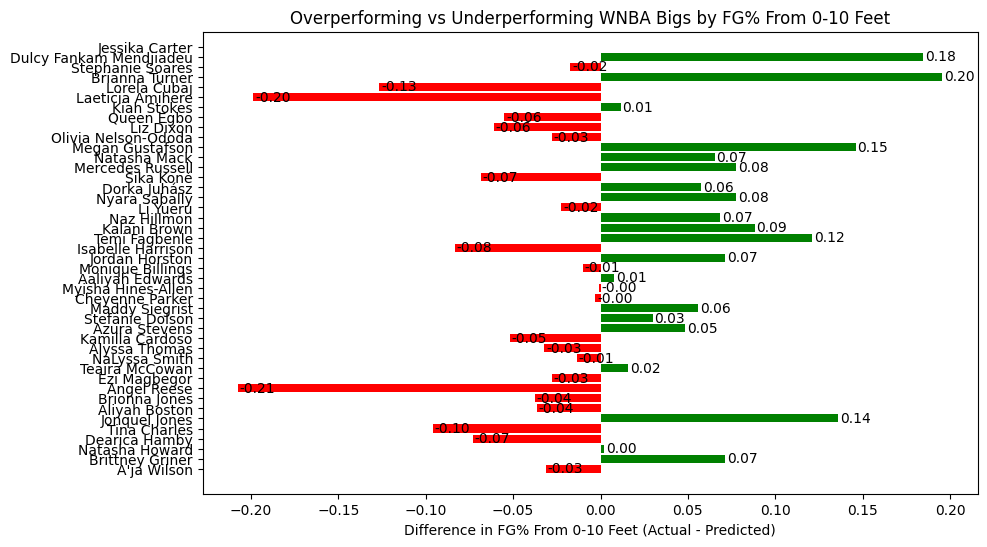

In [15]:
colors = np.where(bigs['FG%_difference'] > 0, 'green', 'red')

plt.figure(figsize=(10, 6))
bars = plt.barh(bigs['Player'], bigs['FG%_difference'], color=colors)
plt.barh(bigs['Player'], bigs['FG%_difference'], color=colors)
plt.xlabel('Difference in FG% From 0-10 Feet (Actual - Predicted)')
plt.title('Overperforming vs Underperforming WNBA Bigs by FG% From 0-10 Feet')

for bar in bars:
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10, color='black')
plt.show()

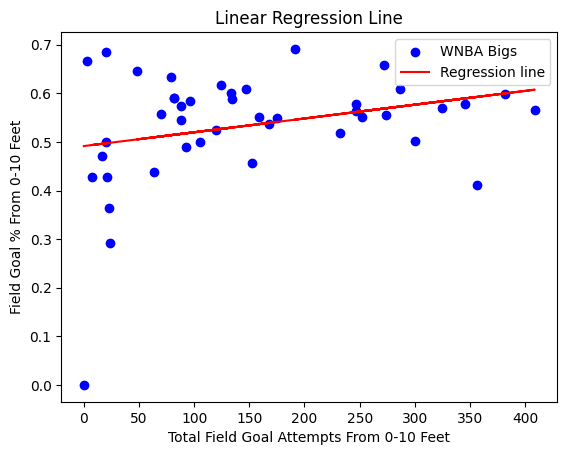

In [16]:
X1 = bigs[['FGA_0-10Tot']]
y1 = bigs['FG%_0-10']

X1 = X1.fillna(0)
y1 = y1.fillna(0)

model = LinearRegression()
model.fit(X1, y1)

y_pred = model.predict(X1)

plt.scatter(X1, y1, color='blue', label='WNBA Bigs')
plt.plot(X1, y_pred, color='red', label='Regression line')
plt.xlabel('Total Field Goal Attempts From 0-10 Feet')
plt.ylabel('Field Goal % From 0-10 Feet')
plt.title('Linear Regression Line')
plt.legend()
plt.show()

In [17]:
print("\nBack to Basket Bigs:")
Sbigs_b2b[['Player', 'Team', 'G', 'GS', 'MP', 'AvgFGDist', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FT%', '%FGA_0-10', 'FG%_0-10', '%FGA_3P', '3PA', '3P%', 'PER', 'USG%', 'WS', 'ShootFoulDrawn', 'OffFoulCmtd', 'And1s']]


Back to Basket Bigs:


,Player,Team,G,GS,MP,AvgFGDist,PTS,TRB,AST,STL,BLK,TOV,FT%,%FGA_0-10,FG%_0-10,%FGA_3P,3PA,3P%,PER,USG%,WS,ShootFoulDrawn,OffFoulCmtd,And1s
27,Aliyah Boston,IND,40,40,1236,6.3,14.0,8.9,3.2,0.9,1.2,2.0,0.736,0.771,0.578857,0.058,0.7,0.269,20.4,20.6,4.5,52,20,10
28,Brionna Jones,CON,40,40,1087,6.2,13.7,5.5,1.5,1.2,0.6,1.3,0.738,0.796,0.569377,0.034,0.4,0.143,21.2,22.3,6.0,74,8,15
29,Angel Reese,CHI,34,34,1104,5.2,13.6,13.1,1.9,1.3,0.5,2.2,0.736,0.852,0.411840,0.038,0.5,0.188,17.6,22.7,2.7,84,17,19
37,Teaira McCowan,DAL,39,38,983,4.6,11.7,8.1,1.6,0.9,0.9,2.0,0.718,0.885,0.608266,0.012,0.1,0.250,20.6,19.8,2.9,57,25,14
42,Alyssa Thomas,CON,40,40,1296,5.5,10.6,8.4,7.9,1.6,0.5,3.6,0.628,0.835,0.555273,0.012,0.1,0.000,19.8,19.1,5.5,66,20,20
47,Kamilla Cardoso,CHI,32,29,876,3.3,9.8,7.9,1.7,0.5,1.4,1.5,0.726,0.954,0.519375,0.000,0.0,NaN,17.5,16.4,2.8,39,12,4
61,Aaliyah Edwards,WAS,34,17,741,6.6,7.6,5.6,1.4,0.7,0.8,1.5,0.650,0.753,0.550675,0.033,0.2,0.000,13.4,18.1,1.6,33,15,4
79,Kalani Brown,DAL,39,2,516,6.2,5.7,3.1,1.1,0.2,0.6,1.2,0.661,0.778,0.617690,0.019,0.1,0.000,16.4,19.3,0.7,31,9,11
80,Naz Hillmon,ATL,40,19,868,5.3,5.7,4.8,1.3,0.7,0.3,1.0,0.762,0.816,0.601583,0.018,0.1,0.333,14.3,11.9,2.7,31,7,7
91,Nyara Sabally,NYL,26,0,352,4.0,4.9,4.0,0.6,0.9,0.7,0.5,0.700,0.954,0.590435,0.023,0.1,0.000,21.0,15.0,2.2,19,4,7


In [18]:
print("\nBalanced Bigs:")
Sbigs_bal[['Player', 'Team', 'G', 'GS', 'MP', 'AvgFGDist', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FT%', '%FGA_0-10', 'FG%_0-10', '%FGA_3P', '3PA', '3P%', 'PER', 'USG%', 'WS', 'ShootFoulDrawn', 'OffFoulCmtd', 'And1s']]


Balanced Bigs:


,Player,Team,G,GS,MP,AvgFGDist,PTS,TRB,AST,STL,BLK,TOV,FT%,%FGA_0-10,FG%_0-10,%FGA_3P,3PA,3P%,PER,USG%,WS,ShootFoulDrawn,OffFoulCmtd,And1s
0,A'ja Wilson,LVA,38,38,1308,10.4,26.9,11.9,2.3,1.8,2.6,1.3,0.844,0.512,0.597664,0.081,1.6,0.317,34.9,32.2,10.9,131,9,30
10,Brittney Griner,PHO,30,30,861,8.0,17.8,6.6,2.3,0.5,1.5,1.8,0.777,0.719,0.657981,0.048,0.6,0.500,26.0,25.6,4.0,63,20,22
12,Natasha Howard,DAL,27,26,825,9.7,17.6,6.7,2.9,1.3,0.8,2.8,0.718,0.602,0.579017,0.134,2.0,0.200,18.1,28.1,0.8,53,11,7
14,Dearica Hamby,LAS,40,40,1346,7.6,17.3,9.2,3.5,1.7,0.2,3.0,0.631,0.780,0.566577,0.168,2.2,0.341,19.2,24.1,3.4,99,22,25
23,Tina Charles,ATL,39,39,1160,9.8,14.9,9.6,2.3,0.9,0.5,1.6,0.785,0.561,0.501660,0.079,1.1,0.262,19.5,25.0,3.7,49,15,11
36,Ezi Magbegor,SEA,37,37,1135,8.1,11.7,8.0,2.0,1.1,2.2,1.4,0.874,0.750,0.551320,0.158,1.4,0.245,19.2,16.5,5.4,42,6,8
41,NaLyssa Smith,IND,40,37,990,8.2,10.6,7.1,1.0,0.8,1.0,1.3,0.567,0.700,0.563083,0.137,1.2,0.292,16.1,20.6,2.0,66,10,19
52,Maddy Siegrist,DAL,27,13,644,9.2,9.4,3.3,1.0,0.4,0.4,0.6,0.767,0.639,0.589310,0.176,1.4,0.270,15.2,16.3,1.1,21,0,5
53,Cheyenne Parker,ATL,25,11,492,8.2,9.2,4.8,1.5,0.8,0.4,2.1,0.886,0.641,0.524861,0.075,0.6,0.214,15.3,24.8,0.9,30,10,5
60,Myisha Hines-Allen,TOT,40,11,746,8.6,7.8,4.7,2.6,0.7,0.1,1.4,0.833,0.717,0.548452,0.205,1.3,0.360,17.3,20.1,2.9,32,10,9


In [19]:
print("\nStretch Bigs:")
Sbigs_stretch[['Player', 'Team', 'G', 'GS', 'MP', 'AvgFGDist', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FT%', '%FGA_0-10', 'FG%_0-10', '%FGA_3P', '3PA', '3P%', 'PER', 'USG%', 'WS', 'ShootFoulDrawn', 'OffFoulCmtd', 'And1s']]


Stretch Bigs:


,Player,Team,G,GS,MP,AvgFGDist,PTS,TRB,AST,STL,BLK,TOV,FT%,%FGA_0-10,FG%_0-10,%FGA_3P,3PA,3P%,PER,USG%,WS,ShootFoulDrawn,OffFoulCmtd,And1s
26,Jonquel Jones,NYL,39,39,1164,13.0,14.2,9.0,3.2,0.8,1.3,2.4,0.788,0.500,0.691362,0.395,3.9,0.388,21.4,20.1,6.5,48,29,14
49,Azura Stevens,LAS,20,19,493,15.1,9.6,7.0,1.9,0.9,0.9,1.8,0.815,0.393,0.556992,0.449,4.0,0.350,14.1,20.4,0.5,14,1,6
50,Stefanie Dolson,WAS,39,39,1013,17.0,9.5,4.9,2.6,0.5,0.5,1.7,0.786,0.314,0.545299,0.554,4.0,0.465,13.6,16.4,2.7,17,17,5
105,Megan Gustafson,LVA,38,7,405,15.2,3.7,1.9,0.2,0.3,0.1,0.4,0.765,0.453,0.645845,0.538,1.5,0.386,12.7,14.5,1.4,7,4,3
135,Kiah Stokes,LVA,39,29,716,17.1,1.4,4.7,0.7,0.5,0.8,0.4,0.667,0.322,0.500481,0.645,1.0,0.225,7.3,5.2,1.5,5,7,1
142,Stephanie Soares,DAL,22,3,175,12.8,1.1,2.1,0.5,0.1,0.4,0.5,1.000,0.500,0.470376,0.353,0.5,0.167,5.7,11.5,-0.3,1,1,0
154,Jessika Carter,LVA,2,0,4,16.3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,NaN,0.000,0.0,NaN,-21.0,21.7,-0.1,1,0,0
